# Burgers' Equation Example

In this notebook we show how to use the PDE solver to solve Burgers' equation in 1D.

Burgers' equation in 1D is
$$
\frac{\partial u}{\partial t} = -u \frac{\partial u}{\partial x} + \nu \frac{\partial^2 u}{\partial x^2},
$$
where $u(x, t)$ is some field with viscosity $\nu$.

We will solve this in a time-stepping approach with an implicit Euler method.

Let's import the required packages:

In [1]:
import time
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax_fno.solvers as solve_ivp

Now, let's solve the Burgers' equation with Dirichlet boundary conditions.

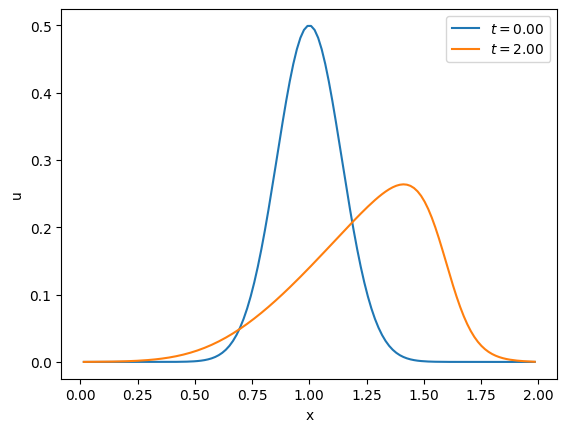

In [2]:
# Solve Burgers' equation with Dirichlet BCs
# Create boundary condition with 0 as the left and right boundary values
bc_type = solve_ivp.BCType.DIRICHLET
bc_values = (0.0, 0.0)

# Viscosity
nu = 0.01

# Define PDE parameters
params = {
    'nu': nu,
    'bc_type': bc_type,
    'bc_left': bc_values[0],
    'bc_right': bc_values[1]
    }

# Load pre-defined functions for the Burgers' equation
# Users have to write their own functions to use the solver for other equations
residual_fn = solve_ivp.burgers_residual_1d
jvp_fn = solve_ivp.burgers_jvp_1d

# Set up grid
L = 2.0  # Domain length
nx = 128  # Number of spatial points in the interior

# Time parameters
t_span = (0.0, 2.0)

# Create Gaussian initial condition
center=1.0
width=0.2
amplitude=0.5
gaussian_ic = jax.jit(lambda x: amplitude * jnp.exp(-((x - center) / width) ** 2))

# Solve the equation
t, x, u = solve_ivp.solve(gaussian_ic, t_span, residual_fn, params, L=L, nx=nx, jvp_fn=jvp_fn, dt=1e-1)

# Plot the solution
fig, ax = plt.subplots()
ax.plot(x, u[0, :], label=f'$t={t[0]:.2f}$')
ax.plot(x, u[-1, :], label=f'$t={t[-1]:.2f}$')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend();

Great! Now, let's solve the same equation with periodic boundary conditions instead. Notice that the initial condition is different.

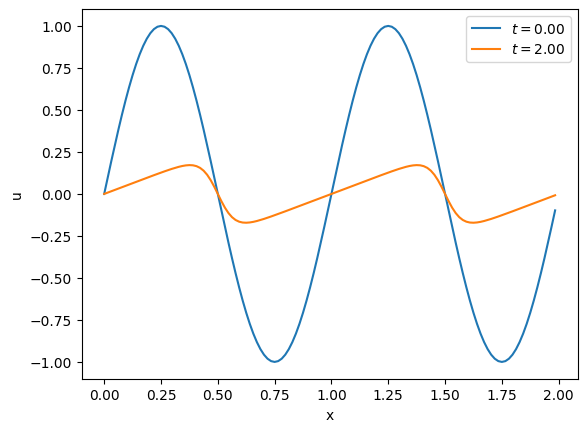

In [3]:
# Solve Burgers' equation with Periodic BCs

# Create boundary condition with 0 as the left and right boundary values
bc_type = solve_ivp.BCType.PERIODIC

# Viscosity
nu = 0.01

# Define PDE parameters
params = {'nu': nu, 'bc_type': bc_type}

# Set up grid
L = 2.0  # Domain length
nx = 128  # Number of spatial points in the interior

# Load pre-defined functions for the Burgers' equation
# Users have to write their own functions to use the solver for other equations
r = solve_ivp.burgers_residual_1d
jvp = solve_ivp.burgers_jvp_1d

# Time parameters
t_span = (0.0, 2.0)

# Create Gaussian initial condition
amplitude=1.0
frequency=2.0
phase=0.0
sine_ic = jax.jit(lambda x: amplitude * jnp.sin(frequency * jnp.pi * x + phase))

# Solve the equation
t, x, u = solve_ivp.solve(sine_ic, t_span, r, params, L=L, nx=nx, jvp_fn=jvp, dt=1e-1)

fig, ax = plt.subplots()
ax.plot(x, u[0, :], label=f'$t={t[0]:.2f}$')
ax.plot(x, u[-1, :], label=f'$t={t[-1]:.2f}$')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend();

In [4]:
import numpy as np

def burgers_rhs_pbc(u, dx, nu):
    u_right = jnp.roll(u, -1)
    u_left = jnp.roll(u, 1)
    dudx = (u_right - u_left) / (2 * dx)
    d2udx2 = (u_right - 2*u + u_left) / (dx**2)
    return -u * dudx + nu * d2udx2

@jax.jit
def explicit_euler_step(u, dt, dx, nu):
    f = burgers_rhs_pbc(u, dx, nu)
    u_new = u + dt * f
    return u_new

def solve_burgers_1d(u0, t_final, dt, dx, nu):
    n_steps = int(t_final / dt)
    
    # Storage for history
    u_history = []
    t_history = []
    
    u = u0.copy()
    t = 0.0
    
    # Store initial condition
    u_history.append(u.copy())
    t_history.append(t)
    
    # Time stepping loop
    for step in range(n_steps):
        u = explicit_euler_step(u, dt, dx, nu)
        t += dt
        
        if step % max(1, n_steps // 100) == 0 or step == n_steps - 1:
            u_history.append(u.copy())
            t_history.append(t)
    
    return u, np.array(t_history), np.array(u_history)

Time taken:  1.8350341320037842
explicit time-step size:  2.384185791015625e-06
Time taken:  13.407601833343506


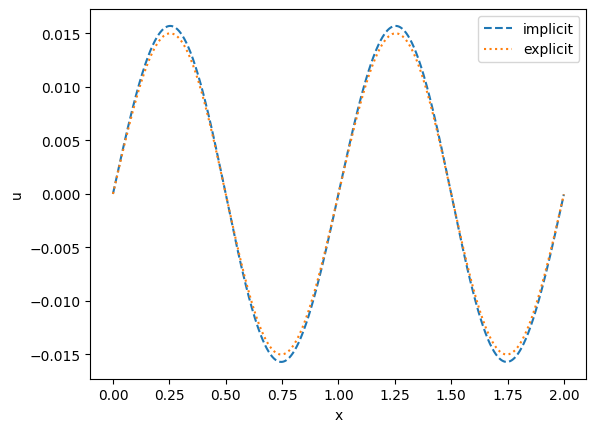

In [9]:
# Setup
nu = 5e-2
bc_type = solve_ivp.BCType.PERIODIC
params = {'nu': nu, 'bc_type': bc_type}
L = 2.0
nx = 4096 
t_span = (0.0, 2.0)

# Governing equation and Jacobian vector product
r = solve_ivp.burgers_residual_1d
jvp = solve_ivp.burgers_jvp_1d

# Initial condition
amplitude=1.0
frequency=2.0
phase=0.0
sine_ic = jax.jit(lambda x: amplitude * jnp.sin(frequency * jnp.pi * x + phase))

# Solve with implicit (BDF + Newton-Raphson) method
start_time = time.time()
t, x, u = solve_ivp.solve(sine_ic, t_span, r, params, L=L, nx=nx, jvp_fn=jvp, dt=1e-2, save_every=100, tol=1e-4, tol_gmres=1e-4)
u.block_until_ready()
elapsed_time = time.time() - start_time
print('Time taken: ', elapsed_time)

# Solve with explicit (midpoint) method
u0 = sine_ic(x)
dx = L / nx
dt = min(dx / jnp.amax(u0), 0.5 * dx**2 / nu)
print('explicit time-step size: ', dt)
start_time = time.time()
uf, _, _ = solve_burgers_1d(u0, t_span[1], dt=dt, dx=dx, nu=nu)
uf.block_until_ready()
elapsed_time = time.time() - start_time
print('Time taken: ', elapsed_time)

fig, ax = plt.subplots()
ax.plot(x, u[-1, :], ls='--', label='implicit')
ax.plot(x, uf, ls=':', label='explicit')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend();